<h2>LOAD AND PREPARE DATASET</h2>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
import mahotas


dataset_dir = 'dataset'
categories = ['true','false']
dataset = []
for category in categories:
    path = os.path.join(dataset_dir,category)
    label = categories.index(category)
    for img in os.listdir(path):
        try:
            imgpath = os.path.join(path,img)
            # read image
            rawimage = cv2.imread(imgpath)
            
            # create pixel features
            rawimage_pixels = np.array(rawimage).flatten()
            
            # create haralick features
            gray = cv2.cvtColor(rawimage, cv2.COLOR_BGR2GRAY)
            rawimage_haralic = mahotas.features.haralick(gray).mean(axis=0)
           
            dataset.append([rawimage_pixels,rawimage_haralic,label])
        except:
            pass

<h2>GENERATE FEATURES USING PCA AND HARALICK FEATURES</h2>

In [5]:
# Shuffle data randomly to generate accurate test and train dataset
random.shuffle(dataset)

pixel_features = []
haralic_features = []
labels = []

for pixel,haralic,label in dataset:
    pixel_features.append(pixel)
    haralic_features.append(haralic)
    labels.append(label)

    
pca = PCA(n_components=13).fit(pixel_features,labels)
pixel_features = pca.transform(pixel_features)


result_features = np.concatenate((pixel_features, haralic_features), axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(result_features,labels,test_size=0.1)

print('Total Feature Length:',len(result_features[0]))
print("Total Train Size:",len(xtrain))
print("Total Test Size:",len(xtest))

Total Feature Length: 26
Total Train Size: 9404
Total Test Size: 1045


<h2>TRAIN AND CALCULATE ACCURACY</h2>

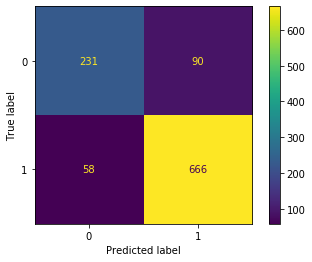

Accuracy: 0.8583732057416268


In [6]:


# SVM results in a lower accuracy than random forest
#model = SVC()

# User random forest classifier with 100 estimators
model=RandomForestClassifier(n_estimators=100)
model.fit(xtrain, ytrain)

ypred = model.predict(xtest)

plot_confusion_matrix(model, xtest, ytest,values_format='d')
plt.show()

print("Accuracy:",accuracy_score(ytest,ypred))

<h2>PREDICTING REAL IMAGES</h2>

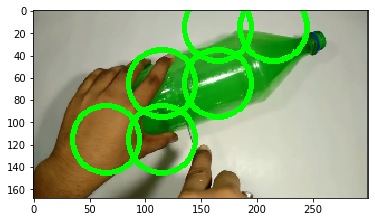

In [33]:
image_path = 'test_images/10.jpg'

test_image = cv2.imread(image_path)

#Resize image
imageScale = test_image.shape[1]/300
dim = (int(test_image.shape[1]/imageScale), int(test_image.shape[0]/imageScale))
test_image = cv2.resize(test_image, dim, interpolation = cv2.INTER_CUBIC)

#Split image into 50x50 pieces and draw circle on positive ones
height, width = test_image.shape[:2]
x_values = range(0,int(width/50)-1)
y_values = range(0,int(height/50))
y=0
x=0
w=50
h=50
for y in y_values:
    for x in x_values:
        y2 = y*50
        x2 = x*50
        crop_img = test_image[y2:y2+h, x2:x2+w]
        features = np.array(crop_img).flatten()
        features = pca.transform([features])[0]
        
        gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
        rawimage_haralic = mahotas.features.haralick(gray).mean(axis=0)
            
        image = np.concatenate((features, rawimage_haralic), axis=0)
        prediction = model.predict([image])
        #print('Prediction is: ', categories[prediction[0]])
        #plt.imshow(crop_img)
        #plt.show()
        if prediction[0] == 0:
            #plt.imshow(crop_img)
            #plt.show()
            test_image = cv2.circle(test_image, (x2+15,y2+15), 30, (0,255,0), 3) 
        
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()